In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd


In [4]:
# 1. Load data
X, y = fetch_covtype(return_X_y=True)  # ~581k samples, 54 features, 7 classes

In [5]:
X, y = fetch_covtype(return_X_y=True)
df = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(X.shape[1])])
df["target"] = y

# Sample 10% from each class
df_sub = (
    df
    .groupby("target", group_keys=False)
    .apply(lambda grp: grp.sample(frac=0.10, random_state=42))
    .reset_index(drop=True)
)

# Split back into X and y if needed
X_filt = df_sub.drop("target", axis=1).values
y_filt = df_sub["target"].values

print("After filtering:", np.bincount(y_filt).astype(int))

After filtering: [    0 21184 28330  3575   275   949  1737  2051]


/tmp/ipython-input-5-1749060449.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(frac=0.10, random_state=42))


In [6]:
# 3. Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_filt, y_filt,
    test_size=0.2,
    stratify=y_filt,
    random_state=42
)

In [7]:
param_dist = {
    'hidden_layer_sizes': [(100,), (100,50), (150,100,50), (200,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [1e-3, 1e-2],
    'batch_size': [64, 128]
}

mlp = MLPClassifier(max_iter=200, random_state=42)

search = RandomizedSearchCV(
    mlp,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
print("Best hyperparameters:", search.best_params_)

best_mlp = search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'solver': 'adam', 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'batch_size': 64, 'alpha': 0.01, 'activation': 'relu'}



Test set performance:
Accuracy : 0.7278
Precision: 0.7373
Recall   : 0.7278
F1-score : 0.7129

Full classification report:
              precision    recall  f1-score   support

           1     0.7761    0.5971    0.6749      4237
           2     0.7123    0.8953    0.7934      5666
           3     0.6779    0.7860    0.7280       715
           4     0.6167    0.6727    0.6435        55
           5     0.6531    0.1684    0.2678       190
           6     0.5876    0.2989    0.3962       348
           7     0.9677    0.2927    0.4494       410

    accuracy                         0.7278     11621
   macro avg     0.7130    0.5302    0.5647     11621
weighted avg     0.7373    0.7278    0.7129     11621



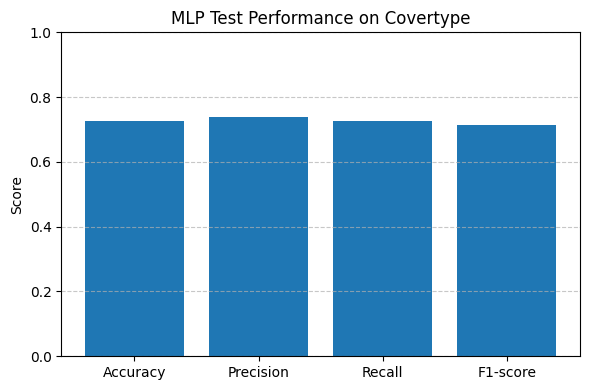

In [8]:
# 5. Evaluate on test set
y_pred = best_mlp.predict(X_test)

acc   = accuracy_score(y_test, y_pred)
prec  = precision_score(y_test, y_pred, average='weighted')
rec   = recall_score(y_test, y_pred, average='weighted')
f1    = f1_score(y_test, y_pred, average='weighted')

print("\nTest set performance:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}\n")

print("Full classification report:")
print(classification_report(y_test, y_pred, digits=4))

# 6. Plot bar chart of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values  = [acc, prec, rec, f1]

plt.figure(figsize=(6,4))
plt.bar(metrics, values)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('MLP Test Performance on Covertype')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

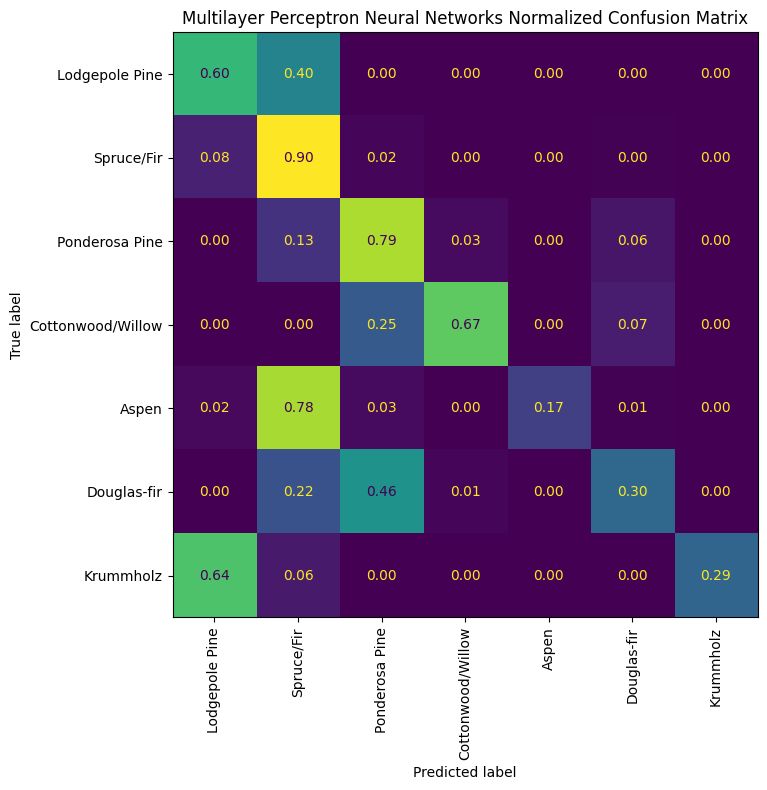

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Your class name mapping
class_names = {
    1: "Lodgepole Pine",
    2: "Spruce/Fir",
    3: "Ponderosa Pine",
    4: "Cottonwood/Willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz"
}

# Prepare labels in order and their display names
labels = list(class_names.keys())
display_labels = [class_names[i] for i in labels]

# Get predictions
y_pred = best_mlp.predict(X_test)

# Compute normalized confusion matrix (rows sum to 1 → per-class recall)
cm_norm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                              display_labels=display_labels)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax,
          xticks_rotation='vertical',
          values_format='.2f',
          colorbar=False)
ax.set_title('Multilayer Perceptron Neural Networks Normalized Confusion Matrix')
plt.tight_layout()
plt.show()